In [1]:
import numpy as np
import vtk
import modules.utility as utility
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import tables
import os
from scipy.interpolate import UnivariateSpline
import SimpleITK as sitk

Using TensorFlow backend.


In [2]:
mhas = open('images.txt').readlines()
mhas = [i.replace('\n','') for i in mhas]
# mhas = [i.split('/')[-1] for i in mhas]
# mhas = ['./data/'+i for i in mhas]

truths = open('truths.txt').readlines()
truths = [i.replace('\n','') for i in truths]

paths = open('paths.txt').readlines()
paths = [i.replace('\n','') for i in paths]

groups = open('groups.txt').readlines()
groups = [i.replace('\n','') for i in groups]

im_mr = open('mr_images.list').readlines()
im_mr = [i.replace('\n','') for i in im_mr]

im_ct = open('ct_images.list').readlines()
im_ct = [i.replace('\n','') for i in im_ct]

ct_val = open('ct_val.txt').readlines()
ct_val = [i.replace('\n','') for i in ct_val]

ct_test = open('ct_test.txt').readlines()
ct_test = [i.replace('\n','') for i in ct_test]

mr_val = open('mr_val.txt').readlines()
mr_val = [i.replace('\n','') for i in mr_val]

mr_test = open('mr_test.txt').readlines()
mr_test = [i.replace('\n','') for i in mr_test]

print mhas

['/home/marsdenlab/datasets/vascular_data/OSMSC0001/OSMSC0001-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0002/OSMSC0002-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0003/OSMSC0003-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0004/OSMSC0004-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0005/OSMSC0005-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0006/OSMSC0006-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0066/OSMSC0066-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0068/OSMSC0068-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0069/OSMSC0069-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0071/OSMSC0071-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0072/OSMSC0072-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0073/OSMSC0073-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0074/OSMSC0074-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0078/OSMSC0078-cm.mha', '/home/marsdenlab/d

In [3]:
def normalize_grps(grp_dict,path_info):
    norm_grps = []
    #print len(path_info)
    #print grp_dict.keys()
    for i in sorted(grp_dict.keys()):

            vecs = path_info[i]
            vecs_g = grp_dict[i]['points']
            p = vecs[:3]
            t = vecs[3:6]
            tx= vecs[6:]
            c = grp_dict[i]['contour']

            contour_norm = utility.normalizeContour(c,p,t,tx)
            norm_grps.append(contour_norm)
    return norm_grps

def reinterp_grps(grps_list, num_pts=20):
    reinterp_list = [
        utility.interpContour(c,num_pts) for c in grps_list
    ]
    return reinterp_list

def loft_path(grps_list, grp_points, num_new_points, k=1):
    """
    Note grp_points and path_points should be sorted
    """
    xsplines = []
    ysplines = []
    
    gpts = np.asarray(grp_points)
    gpts = 1.0*gpts/num_new_points
    
    d = 1.0/num_new_points
    ppts = np.arange(0,1,d)
    
    num_contour_pts = len(grps_list[0])
    
    for i in range(num_contour_pts):
        x = [g[i,0] for g in grps_list]
        y = [g[i,1] for g in grps_list]
        
        x_s = UnivariateSpline(gpts,x,k=k,s=0)
        y_s = UnivariateSpline(gpts,y,k=k,s=0)
        
        xsplines.append(x_s)
        ysplines.append(y_s)
        
    new_grps = []
    for p in ppts:
        cpts = [[xsplines[i](p),ysplines[i](p)] 
                 for i in range(num_contour_pts)]
        new_grps.append(np.asarray(cpts))
        
    return new_grps, xsplines,ysplines

def get_all_lofted_segs(path, grp_fn, dims, spacing):
    
    total_groups = []
    total_segs = []
    processed_grps = []
    for grp_id in path.keys():
        grp = path[grp_id]['name']
        #print grp
        if os.path.exists(grp_fn+'/'+grp):
            
            path_info = path[grp_id]['points']

            grp_dict = utility.parseGroupFile(grp_fn+'/'+grp)
            if len(grp_dict.keys()) == 0: continue
            #print np.amax(grp_dict.keys()), len(path_info)
            if np.amax(grp_dict.keys()) >= len(path_info): continue 
            
            norm_grps = normalize_grps(grp_dict,path_info)

            if len(norm_grps) > 3:
                #print grp
                processed_grps.append(grp)
                
                interp_grps = reinterp_grps(norm_grps)

                lofted_grps,xsplines,ysplies = loft_path(interp_grps,sorted(grp_dict.keys()),len(path_info))

                total_groups += lofted_grps

#                 total_groups += interp_grps

                #origin = [-spacing[0]*dims[0]/2,spacing[1]*dims[1]/2]
                origin = [0.0,0.0]
                segs = [utility.contourToSeg(c,origin,dims,spacing) for c in
                       lofted_grps]

#                 segs = [utility.contourToSeg(c,origin,dims,spacing) for c in
#                         norm_grps]

                total_segs += segs

    return total_segs,total_groups, processed_grps

def resample_image(vtk_im):
    resample = vtk.vtkImageResample();
    spacing = vtk_im.GetSpacing()
    
    #min_ = np.amin(spacing)
    min_ = 0.025
    resample.SetInputData(vtk_im)
    for i in range(3):
        resample.SetAxisOutputSpacing(i,min_)
    resample.Update()
    return resample.GetOutput()

#CT 15
#MR 40
def anomaly(c,y):
    return utility.eccentricity(c) < 0.1 or np.sum(y) < 15
    #return False

output_dir = "/media/marsdenlab/Data2/datasets/DeepLofting/"
ext = [191, 191]
DIMS = [192,192]
NUM_CONTOUR_PTS = 20

In [7]:
print len(groups)
IMAGE_NUMBER = 85
#IMAGE_NUMBER = 78
#IMAGE_NUMBER = np.random.randint(len(mhas))
#IMAGE_NUMBER = 70
#IMAGE_NUMBER = -4
print mhas[IMAGE_NUMBER]
reader = vtk.vtkMetaImageReader()
reader.SetFileName(mhas[IMAGE_NUMBER])
reader.Update()
im = reader.GetOutput()

spacing = im.GetSpacing()
print spacing

# im = resample_image(im)
# spacing = im.GetSpacing()
# print spacing

# print mhas[IMAGE_NUMBER]

98
/home/marsdenlab/datasets/vascular_data/OSMSC0178/OSMSC0178-cm.mha
(0.03516000136733055, 0.03516000136733055, 0.07000389695167542)


In [8]:
DATA_DICT = {}
DATA_DICT['image'] = mhas[IMAGE_NUMBER]
DATA_DICT['image_number'] = IMAGE_NUMBER

grp_files = os.listdir(groups[IMAGE_NUMBER])
print grp_files

path_dict = utility.parsePathFile(paths[IMAGE_NUMBER])
print path_dict.keys()

DATA_DICT['path_dict'] = path_dict
DATA_DICT['grp_files'] = grp_files

anomalies = []
for grpid in path_dict.keys():

    path = path_dict[grpid]['name']
    
    DATA_DICT[path] = {}
    DATA_DICT[path]['id'] = grpid
    print grpid,path

    if not any([g == path for g in grp_files]): continue
    
    id_ = [i for i in range(len(grp_files)) if grp_files[i] == path][0]

    group_dict = utility.parseGroupFile(groups[IMAGE_NUMBER]+'/'+grp_files[id_])

    norm_grps = normalize_grps(group_dict,path_dict[grpid]['points'])

    tmpimages = []
    for v in path_dict[grpid]['points']:
        i =utility.getImageReslice(im,ext,v[:3],v[3:6],v[6:9], True)
        tmpimages.append(i)

    grp_images = []
    for a in sorted(group_dict.keys()):
        v = group_dict[a]['points']
        i =utility.getImageReslice(im,ext,v[:3],v[3:6],v[6:9], True)
        grp_images.append(i)

    interp_grps = reinterp_grps(norm_grps)
    #print interp_grps[0]
    lofted_grps, xs,ys = loft_path(interp_grps,sorted(group_dict.keys()),len(path_dict[grpid]['points']))

    origin = [0.0,0.0]

    segs = [utility.contourToSeg(c,origin,[192,192],spacing) for c in lofted_grps]

    DATA_DICT[path]['group_dict'] = group_dict
    DATA_DICT[path]['norm_grps'] = norm_grps
    DATA_DICT[path]['tmpimages'] = tmpimages
    DATA_DICT[path]['grp_images'] = grp_images
    DATA_DICT[path]['interp_grps'] = interp_grps
    DATA_DICT[path]['lofted_grps'] = lofted_grps
    DATA_DICT[path]['segs'] = segs
    
            
    for i in range(len(lofted_grps)):
        if anomaly(lofted_grps[i],segs[i]):
            t = (grpid,path,i,utility.eccentricity(lofted_grps[i]))
            anomalies.append(t)
            

['L_vtrbl_i', 'R_vtrbl', 'aneurysm_2', 'aneurysm_1', 'L_vtrbl_s', 'group_contents.tcl', 'C_ant', 'C_right', 'C_left', 'R_incrd', 'L_incrd', 'R_ant', 'L_ant']
['200', '900', '600', '300', '700', '450', '500', '400', '100', '800', '1001', '1000']
200 L_incrd
900 C_right
600 L_ant
300 R_vtrbl
700 C_ant
450 L_vtrbl_s
500 R_ant
400 L_vtrbl_i
100 R_incrd
800 C_left
1001 aneurysm_2
1000 aneurysm_1


In [18]:
path='L_incrd'
grpid= DATA_DICT[path]['id']
print DATA_DICT[path]['group_dict'].keys()
print np.amax(DATA_DICT[path]['group_dict'].keys())
print DATA_DICT['path_dict'].keys()
print DATA_DICT['path_dict'][grpid]

[129, 5, 136, 139, 12, 143, 19, 22, 24, 154, 27, 150, 31, 133, 35, 164, 38, 41, 44, 47, 50, 52, 55, 59, 63, 68, 70, 72, 79, 83, 87, 91, 159, 95, 99, 103, 107, 110, 113, 147, 116, 120, 124]
164
['200', '900', '600', '300', '700', '450', '500', '400', '100', '800', '1001', '1000']
{'points': array([[-1.74691 ,  1.78475 , -6.04964 , ...,  0.      ,  0.993821,
         0.110996],
       [-1.749084,  1.783289, -6.037771, ...,  0.      ,  0.99154 ,
         0.129801],
       [-1.755393,  1.778538, -6.004272, ...,  0.      ,  0.988456,
         0.151505],
       ..., 
       [-5.2076  , -2.46359 ,  3.77744 , ...,  0.      ,  0.775573,
        -0.631258],
       [-5.2076  , -2.46359 ,  3.77744 , ...,  0.      ,  0.775573,
        -0.631258],
       [-5.2076  , -2.46359 ,  3.77744 , ...,  0.      ,  0.77557 ,
        -0.631262]]), 'name': 'L_incrd'}


In [6]:
from IPython.display import display, Javascript

disable_js = """
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
"""

def disable_scroll():
    display(Javascript(disable_js))
    print ("autoscrolling long output is disabled")
    
disable_scroll()

print mhas[IMAGE_NUMBER]
k = np.random.randint(len(path_dict.keys()))
k = path_dict.keys()[k]
grp_name =path_dict[k]['name']
# grp_name = 'aorta'
for i in range(5):
    
    id_ = np.random.randint(len(DATA_DICT[grp_name]['grp_images']))
    grp_dict = DATA_DICT[grp_name]['group_dict']
    loft_id = sorted(grp_dict.keys())[id_]
    print grp_name,id_
    
    img = DATA_DICT[grp_name]['grp_images'][id_]
    seg = DATA_DICT[grp_name]['segs'][loft_id]
    
    print "Truth num pixels: ", np.sum(seg)
    
    c   = DATA_DICT[grp_name]['lofted_grps'][loft_id]
    c_grp = DATA_DICT[grp_name]['interp_grps'][id_]
    c_nrm = DATA_DICT[grp_name]['norm_grps'][id_]
    
    extent = [-96*spacing[0],96*spacing[0],-96*spacing[1],96*spacing[1]]
    
    plt.figure()
    plt.imshow(img[:,:],cmap='gray',extent=extent)
    plt.plot(c[:,0],c[:,1],color='b',label='loft')
    plt.plot(c_grp[:,0],c_grp[:,1],color='r',label='interp')
    plt.plot(c_nrm[:,0],c_nrm[:,1],color='g',label='norm')
    plt.legend()
    plt.colorbar()
    plt.show()
    
    plt.figure()
    plt.imshow(seg,cmap='gray',extent=extent)
    plt.plot(c[:,0],c[:,1],color='b',label='loft')
    plt.plot(c_grp[:,0],c_grp[:,1],color='r',label='interp')
    plt.plot(c_nrm[:,0],c_nrm[:,1],color='g',label='norm')
    plt.legend()
    plt.colorbar()
    plt.show()

<IPython.core.display.Javascript object>

autoscrolling long output is disabled
/home/marsdenlab/datasets/vascular_data/OSMSC0187/OSMSC0187-cm.mha


KeyError: 'grp_images'

In [ ]:
from IPython.display import display, Javascript

disable_js = """
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
"""

def disable_scroll():
    display(Javascript(disable_js))
    print ("autoscrolling long output is disabled")
    
disable_scroll()

print mhas[IMAGE_NUMBER]
k = np.random.randint(len(path_dict.keys()))
k = path_dict.keys()[k]
grp_name =path_dict[k]['name']
# grp_name = 'aorta'
for i in range(5):
    
    id_ = np.random.randint(len(DATA_DICT[grp_name]['tmpimages']))
    print grp_name,id_
    
    img = DATA_DICT[grp_name]['tmpimages'][id_]
    seg = DATA_DICT[grp_name]['segs'][id_]
    
    print "Truth num pixels: ", np.sum(seg)
    
    c   = DATA_DICT[grp_name]['lofted_grps'][id_]
    
    extent = [-96*spacing[0],96*spacing[0],-96*spacing[1],96*spacing[1]]
    
    plt.figure()
    plt.imshow(img[:,:],cmap='gray',extent=extent)
    plt.plot(c[:,0],c[:,1],color='b',label='loft')
    plt.legend()
    plt.colorbar()
    plt.show()
    
    plt.figure()
    plt.imshow(seg,cmap='gray',extent=extent)
    plt.plot(c[:,0],c[:,1],color='b',label='loft')
    plt.legend()
    plt.colorbar()
    plt.show()

In [18]:
print mhas[IMAGE_NUMBER]
for i in range(5):
    j = np.random.randint(len(anomalies))
    print anomalies[j]
    grpid,grp_name,id_,e = anomalies[j]
    
    img = DATA_DICT[grp_name]['tmpimages'][id_]
    seg = DATA_DICT[grp_name]['segs'][id_]
    c   = DATA_DICT[grp_name]['lofted_grps'][id_]
    
    extent = [-96*spacing[0],96*spacing[0],-96*spacing[1],96*spacing[1]]
    
    plt.figure()
    plt.imshow(img[:,:],cmap='gray',extent=extent)
    plt.plot(c[:,0],c[:,1],color='b',label='loft')
    plt.legend()
    plt.colorbar()
    plt.show()
    
    plt.figure()
    plt.imshow(seg,cmap='gray',extent=extent)
    plt.plot(c[:,0],c[:,1],color='b',label='loft')
    plt.legend()
    plt.colorbar()
    plt.show()

/home/marsdenlab/datasets/vascular_data/OSMSC0079/OSMSC0079-cm.mha


ValueError: low >= high

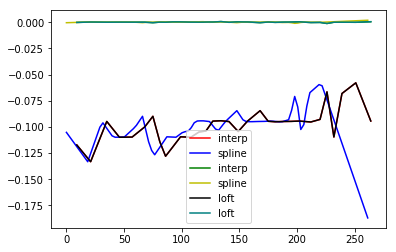

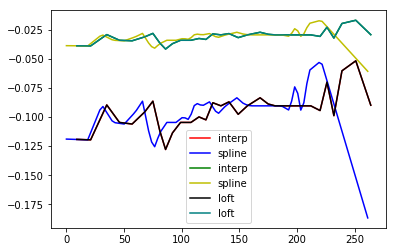

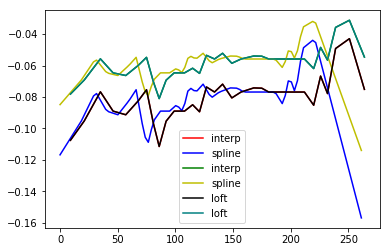

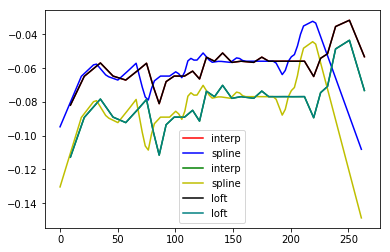

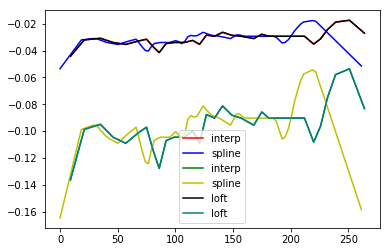

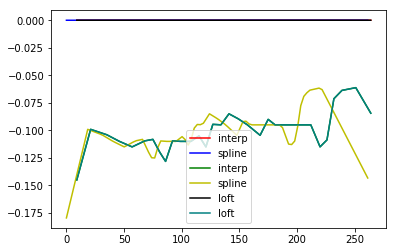

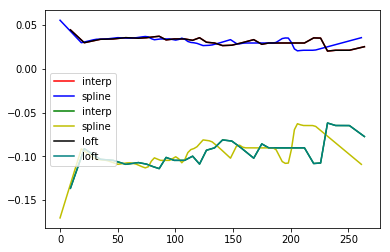

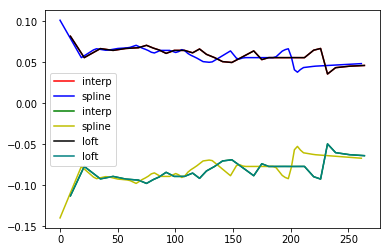

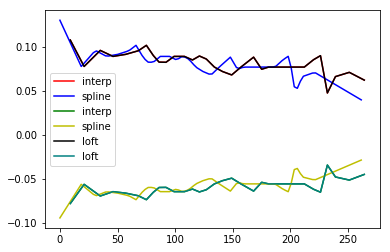

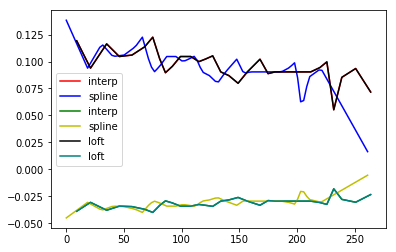

In [19]:
gs = [lofted_grps[j] for j in sorted(group_dict.keys())]
for j in range(10):
    gs_points = [g[j,0] for g in gs]
    gs_points_y = [g[j,1] for g in gs]
    
    grp_points = [g[j,0] for g in interp_grps]
    grp_points_y = [g[j,1] for g in interp_grps]
    
    pts = np.arange(0,1,1.0/100)
    sp_points = [xs[j](p) for p in pts]
    sp_points_y = [ys[j](p) for p in pts]
    gpts = np.asarray(sorted(group_dict.keys()))
    lpts = np.arange(0,np.amax(gpts),1.0*np.amax(gpts)/100)
    #gpts = 1.0*gpts/np.amax(gpts)

    plt.figure()
    plt.plot(gpts,grp_points,color='r',label='interp')
    plt.plot(lpts[:100],sp_points,color='b',label='spline')
    plt.plot(gpts,grp_points_y,color='g',label='interp')
    plt.plot(lpts[:100],sp_points_y,color='y',label='spline')
    plt.plot(gpts,gs_points,color='k',label='loft')
    plt.plot(gpts,gs_points_y,color='teal',label='loft')
    plt.legend()
    plt.show()


In [5]:
from IPython.display import display, Javascript

disable_js = """
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
"""

def disable_scroll():
    display(Javascript(disable_js))
    print ("autoscrolling long output is disabled")
    
disable_scroll()
k = sorted(group_dict.keys())
for i in range(len(grp_images)):
    j = i
    print j
    seg_ind = k[j]
    extent = [-96*spacing[0],96*spacing[0],-96*spacing[1],96*spacing[1]]
    c = norm_grps[j]
    c2 = interp_grps[j]
    plt.figure()
    plt.imshow(grp_images[j][:,:],cmap='gray',extent=extent)
    plt.plot(c[:,0],c[:,1],color='b',label='norm')
    plt.plot(c2[:,0],c2[:,1],color='r',label='interp')
    plt.legend()
    plt.colorbar()
    plt.show()
    
    plt.figure()
    plt.imshow(segs[seg_ind][:,:],cmap='gray',extent=extent)
    plt.plot(c[:,0],c[:,1],color='b',label='norm')
    plt.plot(c2[:,0],c2[:,1],color='r',label='interp')
    plt.legend()
    plt.colorbar()
    plt.show()

<IPython.core.display.Javascript object>

autoscrolling long output is disabled


NameError: name 'group_dict' is not defined

In [7]:
def ct_norm(x):
    return (1.0*x)/(3000)

def mr_norm(x):
    #x = np.log(1.0*x-np.amin(x)+1)
#     m = np.amin(x,axis=(1,2,3), keepdims=True)
#     max_ = np.amax(x,axis=(1,2,3), keepdims=True)
    m = np.amin(x)
    max_ = np.amax(x)
    x = 2.0*(1.0*x-m)/(max_-m)-1.0    
    return x

def image_reader(fn_tup):
    
    img_fn, truth_fn, path_fn, grp_fn = fn_tup
    reader = vtk.vtkMetaImageReader()
    reader2 = vtk.vtkMetaImageReader()
    
    img_name = img_fn.split('/')[-2]

    reader.SetFileName(img_fn)
    reader.Update()
    the_image = reader.GetOutput()
    the_image = resample_image(the_image)
    
    model = truth_fn
    model_name = model.split('/')[-2]

    print img_fn,truth_fn

    reader2.SetFileName(model)
    reader2.Update()
    the_model = reader2.GetOutput()
    the_model = resample_image(the_model)
    
    path_dict = utility.parsePathFile(path_fn)
    
    return (the_image,the_model,path_dict,grp_fn)

def process_image(data_tup, f_x, f_y, f_c, meta, normalizer):
    the_image, the_model, path_dict, grp_fn = data_tup

    spacing = the_image.GetSpacing()
    dims = the_image.GetDimensions()
    origin = [-ext[0]*spacing[0]/2,ext[1]*spacing[1]/2]
    minmax = the_image.GetScalarRange()    

    tmpimages, tmpsegs, lofted_grps = get_image(data_tup,normalizer)
    
    if not len(tmpimages) == 0:
        META = np.zeros((len(tmpimages),2))
        META[:] = spacing[:2]
        print META[:10]
        print META.shape
        f_x.append(tmpimages.copy())
        f_y.append(tmpsegs.copy())
        f_c.append(lofted_grps.copy())
        meta.append(META.copy())
        print "done appending"

def get_image(data_tup, normalizer):
    the_image, the_model, path_dict, grp_fn = data_tup

    spacing = the_image.GetSpacing()
    dims = the_image.GetDimensions()
    origin = [-ext[0]*spacing[0]/2,ext[1]*spacing[1]/2]
    minmax = the_image.GetScalarRange()    

    #tmpimages = utility.getAllImageSlices(the_image, path_dict, ext, True)
    #tmpsegs = utility.getAllImageSlices(the_model, path_dict, ext, True)
           
    tmpsegs, lofted_grps, grp_names = get_all_lofted_segs(path_dict,grp_fn,DIMS,spacing)

    tmpimages = []
    strings = []
    for p in path_dict.keys():
        grp = path_dict[p]['name']
        if os.path.exists(grp_fn+'/'+grp) and any([grp == g for g in grp_names]):
            print 'grp {} exists, getting images'.format(grp)
            COUNT = 0
            for v in path_dict[p]['points']:
                i =utility.getImageReslice(the_image,ext,v[:3],v[3:6],v[6:9], True)
                tmpimages.append(i)
                strings.append("{},{},{}\n".format(grp_fn.split('/')[-1],grp,COUNT))
                COUNT+=1
                
    if len(tmpimages) > 0:
        tmpimages = np.asarray(tmpimages)[:,:,:,np.newaxis]
        tmpsegs = np.asarray(tmpsegs)[:,:,:,np.newaxis]
        lofted_grps = np.asarray(lofted_grps)
        print tmpimages.shape, tmpsegs.shape
#     tmpimages = np.transpose(tmpimages,axes=(0,2,3,1))
#     tmpsegs = np.transpose(tmpsegs,axes=(0,2,3,1))
    
        tmpimages = normalizer(tmpimages)
        tmpsegs = 1.0*tmpsegs/np.amax(tmpsegs)
        inds = [i for i in range(len(tmpimages)) if np.sum(tmpsegs[i])>0]
        inds = [i for i in inds if not anomaly(lofted_grps[i],tmpsegs[i])]
        for INDEX in inds:
            if not THE_FILE.closed: THE_FILE.write(strings[INDEX])
        return tmpimages[inds].copy(), tmpsegs[inds].copy(), lofted_grps[inds].copy()
    else:
        return [],[],[]

In [6]:
import SimpleITK as sitk
print mhas[IM_NUM]
im = sitk.ReadImage(mhas[IM_NUM])
spacing = im.GetSpacing()
print spacing

NameError: name 'IM_NUM' is not defined

In [8]:
def images_to_hdf5(image_list,
                   reader, post_processor, normalizer,shape, label_shape, dtype, label_dtype,
                   output_fn):
    """
    takes a list of images, post processes them and stores result in extendable
    hdf5 table
    
    inputs:
        - image_list, (list of strings), list of image filenames, readable by reader
        - reader, (function), reader compatible with the file type in image_list
        - post_processor, (function), post processes output of reader, must return list of np arrays with same shape
        - output_fn, (string), ouput filename, must be hdf5 file
    """
    EXPECTED_ROWS = 10000
    
    #create hdf5 file
    hdf5_file = tables.open_file(output_fn,'w')
    filters = tables.Filters(complevel=5, complib='blosc')
    
    data_storage = hdf5_file.create_earray(hdf5_file.root,'X',
                                      tables.Atom.from_dtype(dtype),
                                      shape=[0]+list(shape),
                                         filters=filters,
                                         expectedrows=EXPECTED_ROWS)
    
    label_storage = hdf5_file.create_earray(hdf5_file.root,'Y',
                                      tables.Atom.from_dtype(label_dtype),
                                      shape=[0]+list(label_shape),
                                         filters=filters,
                                         expectedrows=EXPECTED_ROWS)
    
    contour_shape = [NUM_CONTOUR_PTS,2]
    c_storage = hdf5_file.create_earray(hdf5_file.root,'C',
                                  tables.Atom.from_dtype(label_dtype),
                                  shape=[0]+contour_shape,
                                     filters=filters,
                                     expectedrows=EXPECTED_ROWS)

    meta = hdf5_file.create_earray(hdf5_file.root,'meta',
                                  tables.Atom.from_dtype(label_dtype),
                                  shape=[0,2],
                                     filters=filters,
                                     expectedrows=EXPECTED_ROWS)
    for i in range(len(image_list)):
        print 'image {}'.format(i)
        data_tuple = reader(image_list[i])
        
        post_processor(data_tuple,data_storage,label_storage,c_storage,meta,normalizer)
            
    hdf5_file.close()

In [9]:
train_ct = '/media/marsdenlab/Data2/datasets/DeepLofting/train_192_ct.hdf5'
val_ct = '/media/marsdenlab/Data2/datasets/DeepLofting/val_192_ct.hdf5'
test_ct = '/media/marsdenlab/Data2/datasets/DeepLofting/test_192_ct.hdf5'

train_mr = '/media/marsdenlab/Data2/datasets/DeepLofting/train_192_mr.hdf5'
val_mr = '/media/marsdenlab/Data2/datasets/DeepLofting/val_192_mr.hdf5'
test_mr = '/media/marsdenlab/Data2/datasets/DeepLofting/test_192_mr.hdf5'

train_combined = '/media/marsdenlab/Data2/datasets/DeepLofting/train_192_combined.hdf5'
val_combined = '/media/marsdenlab/Data2/datasets/DeepLofting/val_192_combined.hdf5'
test_combined = '/media/marsdenlab/Data2/datasets/DeepLofting/test_192_combined.hdf5'

In [10]:
ct_inds = [i for i in range(len(mhas)) if any([c in mhas[i] for c in im_ct])]
mr_inds = [i for i in range(len(mhas)) if any([c in mhas[i] for c in im_mr])]
ct_fn_tup = [(mhas[i],truths[i],paths[i],groups[i]) for i in ct_inds]
mr_fn_tup = [(mhas[i],truths[i],paths[i],groups[i]) for i in mr_inds]

print ct_fn_tup
print mr_fn_tup

[('/home/marsdenlab/datasets/vascular_data/OSMSC0001/OSMSC0001-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0001/0001_0001/0001_0001-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0001/0001_0001/0001_0001-cm.paths', '/home/marsdenlab/datasets/vascular_data/OSMSC0001/0001_0001/0001_0001_groups-cm'), ('/home/marsdenlab/datasets/vascular_data/OSMSC0002/OSMSC0002-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0002/0002_0001/0002_0001-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0002/0002_0001/0002_0001-cm.paths', '/home/marsdenlab/datasets/vascular_data/OSMSC0002/0002_0001/0002_0001_groups-cm'), ('/home/marsdenlab/datasets/vascular_data/OSMSC0003/OSMSC0003-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0003/0003_0001/0003_0001-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0003/0003_0001/0003_0001-cm.paths', '/home/marsdenlab/datasets/vascular_data/OSMSC0003/0003_0001/0003_0001_groups-cm'), ('/home/marsdenlab/datasets/vascular_data/OSMSC0

In [11]:
ct_train_tups = []
ct_val_tups = []
ct_test_tups = []

for i in range(len(ct_fn_tup)):
    t = ct_fn_tup[i]
    fn = t[0]
    
    if any([c in fn for c in ct_val]):
        ct_val_tups.append(t)
    elif any([c in fn for c in ct_test]):
        ct_test_tups.append(t)
    else:
        ct_train_tups.append(t)
        
print "train"
print ct_train_tups

print "val"
print ct_val_tups

print "test"
print ct_test_tups

train
[('/home/marsdenlab/datasets/vascular_data/OSMSC0002/OSMSC0002-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0002/0002_0001/0002_0001-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0002/0002_0001/0002_0001-cm.paths', '/home/marsdenlab/datasets/vascular_data/OSMSC0002/0002_0001/0002_0001_groups-cm'), ('/home/marsdenlab/datasets/vascular_data/OSMSC0003/OSMSC0003-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0003/0003_0001/0003_0001-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0003/0003_0001/0003_0001-cm.paths', '/home/marsdenlab/datasets/vascular_data/OSMSC0003/0003_0001/0003_0001_groups-cm'), ('/home/marsdenlab/datasets/vascular_data/OSMSC0005/OSMSC0005-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0005/0005_1001/0005_1001-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0005/0005_1001/0005_1001-cm.paths', '/home/marsdenlab/datasets/vascular_data/OSMSC0005/0005_1001/0005_1001_groups-cm'), ('/home/marsdenlab/datasets/vascular_data/

In [ ]:
d = np.dtype(np.float32)

THE_FILE = open('ct_train_list.txt','w')
images_to_hdf5(ct_train_tups,
                   image_reader,
                   process_image, ct_norm, (ext[0]+1,ext[0]+1,1), (ext[0]+1,ext[1]+1,1), d, d,
                   train_ct)
THE_FILE.close()

print "DONE TRAIN CT"
THE_FILE = open('ct_val_list.txt','w')
images_to_hdf5(ct_val_tups,
                   image_reader,
                   process_image, ct_norm, (ext[0]+1,ext[1]+1,1), (ext[0]+1,ext[1]+1,1),d, d,
                   val_ct)
THE_FILE.close()

print "DONE VAL CT"

THE_FILE = open('ct_test_list.txt','w')
images_to_hdf5(ct_test_tups,
                   image_reader,
                   process_image, ct_norm, (ext[0]+1,ext[1]+1,1), (ext[0]+1,ext[1]+1,1), d, d,
                   test_ct)
THE_FILE.close()

print "DONE TEST CT"

image 0
/home/marsdenlab/datasets/vascular_data/OSMSC0002/OSMSC0002-cm.mha /home/marsdenlab/datasets/vascular_data/OSMSC0002/0002_0001/0002_0001-cm.mha
grp LCX_b1 exists, getting images
grp RCA_b4 exists, getting images
grp LAD_b3_b1 exists, getting images
grp RCA_b1_b1 exists, getting images
grp RCA_b1 exists, getting images
grp RCA_b2 exists, getting images
grp RCA_b3 exists, getting images
grp RCA_b3_b1 exists, getting images
grp LCX_b4_b1 exists, getting images
grp aorta exists, getting images
grp LCX exists, getting images
grp LAD exists, getting images
grp LAD_b1 exists, getting images
grp RCA exists, getting images
grp LAD_b3 exists, getting images
grp LAD_b2 exists, getting images
grp LAD_b5 exists, getting images
grp LAD_b4 exists, getting images
grp aorta exists, getting images
grp RCA_b3 exists, getting images
grp RCA_b4 exists, getting images
grp aorta exists, getting images
grp LAD_b2 exists, getting images
grp LAD_b6 exists, getting images
grp LCX_b2 exists, getting image

done appending
image 7
/home/marsdenlab/datasets/vascular_data/OSMSC0115/OSMSC0115-cm.mha /home/marsdenlab/datasets/vascular_data/OSMSC0115/0115_0005/0115_0005-cm.mha
grp NRCA_4 exists, getting images
grp RCA_1 exists, getting images
grp NRCA_3 exists, getting images
grp NRCA_2 exists, getting images
grp NLCA_4 exists, getting images
grp NLCA_5 exists, getting images
grp NLCA_6 exists, getting images
grp NLCA_7 exists, getting images
grp NLCA_2 exists, getting images
grp NLCA_3 exists, getting images
grp NRCA_1 exists, getting images
grp RSA_b3 exists, getting images
grp RSA_b2 exists, getting images
grp RSA_b1 exists, getting images
grp RSA exists, getting images
grp RCCA exists, getting images
grp LCA_1 exists, getting images
grp LIMA exists, getting images
grp LSA exists, getting images
grp LSA_b2 exists, getting images
grp LSA_b1 exists, getting images
grp LSA_b4 exists, getting images
grp LSA_b3 exists, getting images
grp LCCA exists, getting images
grp aorta exists, getting image

(3700, 192, 192, 1) (3700, 192, 192, 1)
[[ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]]
(3366, 2)
done appending
image 17
/home/marsdenlab/datasets/vascular_data/OSMSC0145/OSMSC0145-cm.mha /home/marsdenlab/datasets/vascular_data/OSMSC0145/0145_1001/0145_1001-cm.mha
grp aneurysm_2 exists, getting images
grp ext_iliac_left exists, getting images
grp aneurysm_1 exists, getting images
grp IMA exists, getting images
grp int_iliac_right exists, getting images
grp SMA exists, getting images
grp aneurysm_3 exists, getting images
grp renal_left exists, getting images
grp celiac_splenic exists, getting images
grp int_iliac_left exists, getting images
grp renal_right exists, getting images
grp aorta exists, getting images
grp celiac_hepatic exists, getting images
(3100, 192, 192, 1) (3100, 192, 192, 1)
[[ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.0

grp intercostal_14b exists, getting images
grp intercostal_13a exists, getting images
grp r_iliac_b1 exists, getting images
grp l_fem_b15 exists, getting images
grp l_fem_b14 exists, getting images
grp l_fem_b13 exists, getting images
grp l_fem_b12 exists, getting images
grp l_fem_b19 exists, getting images
grp l_fem_b18 exists, getting images
grp l_fem_b17 exists, getting images
grp l_fem_b16 exists, getting images
grp l_fem_b21 exists, getting images
grp l_fem_b20 exists, getting images
grp intercostal_13b exists, getting images
grp r_fem_b31 exists, getting images
grp r_fem_b32 exists, getting images
grp r_fem_b29 exists, getting images
grp r_fem_b30 exists, getting images
grp r_fem_b27 exists, getting images
grp r_fem_b28 exists, getting images
grp l_in_iliac_b3 exists, getting images
grp r_fem_b26 exists, getting images
grp l_in_iliac_b1 exists, getting images
grp l_in_iliac_b2 exists, getting images
grp l_profunda exists, getting images
grp l_profunda_b1 exists, getting images
gr

(100, 192, 192, 1) (100, 192, 192, 1)
[[ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]]
(100, 2)
done appending
image 34
/home/marsdenlab/datasets/vascular_data/OSMSC0185/OSMSC0185-cm.mha /home/marsdenlab/datasets/vascular_data/OSMSC0185/0185_0001/0185_0001-cm.mha
grp coronary_left1s exists, getting images
grp coronary_left2s exists, getting images
grp coronary_left3s exists, getting images
grp coronary_right1s exists, getting images
grp aorta_2Snew exists, getting images
(1500, 192, 192, 1) (1500, 192, 192, 1)
[[ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]]
(1317, 2)
done appending
image 35
/home/marsdenlab/datasets/vascular_data/OSMSC0186/OSMSC0186-cm.mha /home/marsdenlab/datasets/vascular_data/OSMSC0186/0186_0002/0186_0002-cm.mha
grp rc1_sub1 

grp RPA_br7_br6 exists, getting images
grp RPA_br9_br1 exists, getting images
grp RPA_br7_br8 exists, getting images
grp RPA_br7_br2 exists, getting images
grp RPA_br7_br5 exists, getting images
grp RPA_br7_br4 exists, getting images
grp LPA_br4_br4 exists, getting images
grp RPA_br7 exists, getting images
grp RPA_br8 exists, getting images
grp RPA_br2_br1 exists, getting images
grp RPA_br1_br2_b4 exists, getting images
grp RPA_br1_br2_b3 exists, getting images
grp LPA_br11 exists, getting images
grp LPA_br10 exists, getting images
grp LPA_br9 exists, getting images
grp LPA_br8 exists, getting images
grp LPA_br7 exists, getting images
grp RPA_br1_br2_b2_b1 exists, getting images
grp RPA_br6 exists, getting images
grp LPA_br4_b2 exists, getting images
grp LPA_br4_br1_br1 exists, getting images
grp LPA_br4_br1 exists, getting images
grp LPA_br10_br7 exists, getting images
grp RPA_br5 exists, getting images
grp LPA_br5_br2 exists, getting images
grp LPA_br5_br2_b1 exists, getting images
g

In [10]:
f = tables.open_file(test_ct,'r')
print f.root.X.shape

(42694, 192, 192, 1)


In [11]:
counts = np.sum(f.root.Y,axis=(1,2,3))

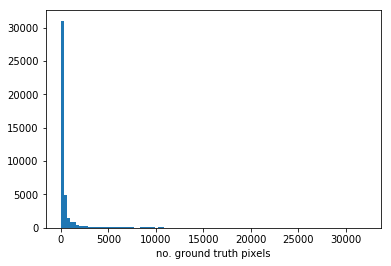

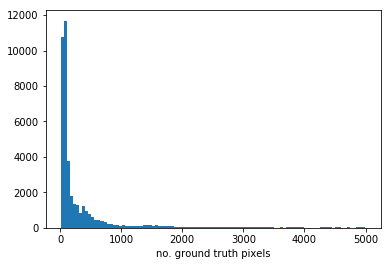

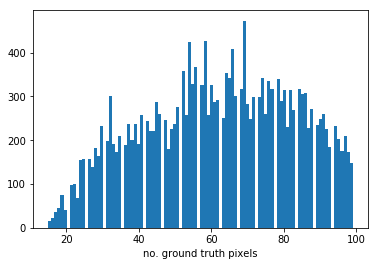

In [12]:
plt.figure()
plt.hist(counts,bins=100)
plt.xlabel('no. ground truth pixels')
plt.savefig('ct_hist.pdf',dpi=500)
plt.show()
plt.close()

plt.figure()
plt.hist(counts[counts<5000],bins=100)
plt.xlabel('no. ground truth pixels')
plt.savefig('ct_hist_red.pdf',dpi=500)
plt.show()
plt.close()

plt.figure()
plt.hist(counts[counts<100],bins=100)
plt.xlabel('no. ground truth pixels')
plt.savefig('ct_hist_red_2.pdf',dpi=500)
plt.show()
plt.close()

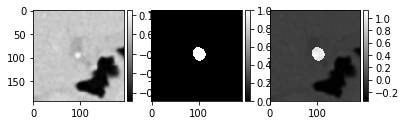

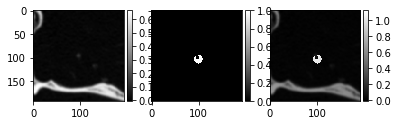

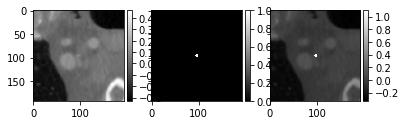

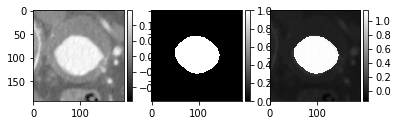

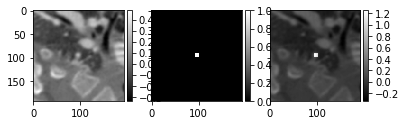

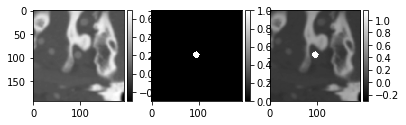

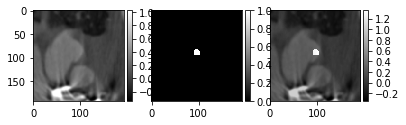

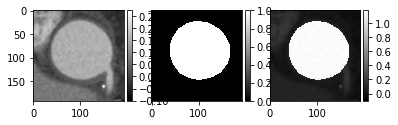

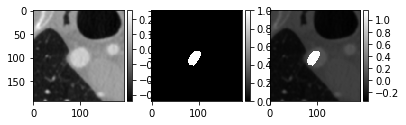

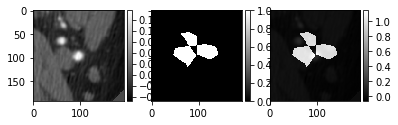

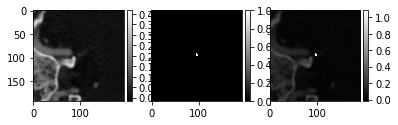

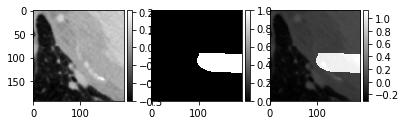

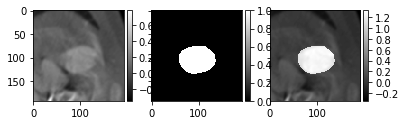

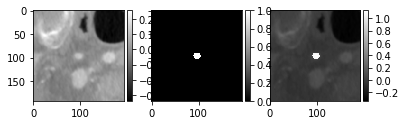

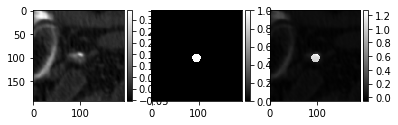

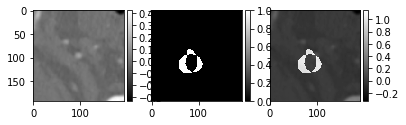

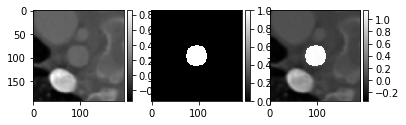

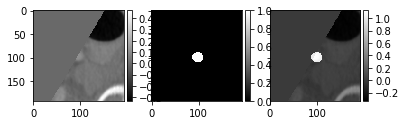

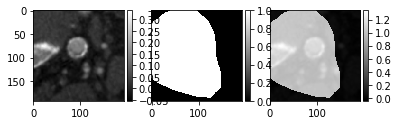

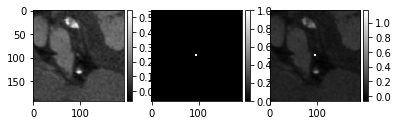

In [13]:
def implot(mp,ax):
    im = ax.imshow(mp.astype(np.float32), cmap='gray')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    
for i in range(20):
    j = np.random.randint(len(f.root.X))

    plt.figure()
    fig, (ax1, ax2,ax3) = plt.subplots(1, 3, sharey=True)
    implot(f.root.X[j,:,:,0],ax1)
    implot(f.root.Y[j,:,:,0],ax2)
    implot(f.root.X[j,:,:,0]+f.root.Y[j,:,:,0],ax3)
    plt.tight_layout
    plt.show()
    
plt.close('all')

In [9]:
mr_train_tups = []
mr_val_tups = []
mr_test_tups = []

for i in range(len(mr_fn_tup)):
    t = mr_fn_tup[i]
    fn = t[0]
    
    if any([c in fn for c in mr_val]):
        mr_val_tups.append(t)
    elif any([c in fn for c in mr_test]):
        mr_test_tups.append(t)
    else:
        mr_train_tups.append(t)
        
print "train"
print mr_train_tups

print "val"
print mr_val_tups

print "test"
print mr_test_tups

train
[('/home/marsdenlab/datasets/vascular_data/OSMSC0066/OSMSC0066-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0066/0066_0001/0066_0001-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0066/0066_0001/0066_0001-cm.paths', '/home/marsdenlab/datasets/vascular_data/OSMSC0066/0066_0001/0066_0001_groups-cm'), ('/home/marsdenlab/datasets/vascular_data/OSMSC0068/OSMSC0068-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0068/0068_0001/0068_0001-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0068/0068_0001/0068_0001-cm.paths', '/home/marsdenlab/datasets/vascular_data/OSMSC0068/0068_0001/0068_0001_groups-cm'), ('/home/marsdenlab/datasets/vascular_data/OSMSC0069/OSMSC0069-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0069/0069_0001/0069_0001-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0069/0069_0001/0069_0001-cm.paths', '/home/marsdenlab/datasets/vascular_data/OSMSC0069/0069_0001/0069_0001_groups-cm'), ('/home/marsdenlab/datasets/vascular_data/

In [10]:
d = np.dtype(np.float32)
THE_FILE = open('mr_train_list.txt','w')
images_to_hdf5(mr_train_tups,
                   image_reader,
                   process_image, mr_norm, (ext[0]+1,ext[0]+1,1), (ext[0]+1,ext[1]+1,1), d, d,
                   train_mr)
THE_FILE.close()

THE_FILE = open('mr_val_list.txt','w')
images_to_hdf5(mr_val_tups,
                   image_reader,
                   process_image, mr_norm, (ext[0]+1,ext[1]+1,1), (ext[0]+1,ext[1]+1,1),d, d,
                   val_mr)
THE_FILE.close()

THE_FILE = open('mr_test_list.txt','w')
images_to_hdf5(mr_test_tups,
                   image_reader,
                   process_image, mr_norm, (ext[0]+1,ext[1]+1,1), (ext[0]+1,ext[1]+1,1), d, d,
                   test_mr)
THE_FILE.close()

image 0
/home/marsdenlab/datasets/vascular_data/OSMSC0066/OSMSC0066-cm.mha /home/marsdenlab/datasets/vascular_data/OSMSC0066/0066_0001/0066_0001-cm.mha
grp RSA exists, getting images
grp RCCA exists, getting images
grp LSA exists, getting images
grp LCCA exists, getting images
(400, 192, 192, 1) (400, 192, 192, 1)
[[ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]]
(389, 2)
done appending
image 1
/home/marsdenlab/datasets/vascular_data/OSMSC0068/OSMSC0068-cm.mha /home/marsdenlab/datasets/vascular_data/OSMSC0068/0068_0001/0068_0001-cm.mha
grp Aorta exists, getting images
grp RCCA exists, getting images
grp RSA exists, getting images
grp LSA exists, getting images
grp LCCA exists, getting images
(700, 192, 192, 1) (700, 192, 192, 1)
[[ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0

grp RPA_23 exists, getting images
grp RPA_22 exists, getting images
grp RPA_19 exists, getting images
grp RPA_18 exists, getting images
grp RPA_21 exists, getting images
grp RPA_20 exists, getting images
grp RPA_15 exists, getting images
grp RPA_14 exists, getting images
grp RPA_17 exists, getting images
grp RPA_16 exists, getting images
grp RPA_52 exists, getting images
grp RPA_53 exists, getting images
grp RPA_46 exists, getting images
grp RPA_47 exists, getting images
grp RPA_44 exists, getting images
grp RPA_45 exists, getting images
grp RPA_50 exists, getting images
grp RPA_51 exists, getting images
grp RPA_48 exists, getting images
grp RPA_49 exists, getting images
grp LPA_02 exists, getting images
grp LPA_06 exists, getting images
grp RPA_03 exists, getting images
grp RPA_02 exists, getting images
grp LPA_32 exists, getting images
grp LPA_31 exists, getting images
grp LPA_30 exists, getting images
grp LPA_29 exists, getting images
grp RPA_01 exists, getting images
grp LPA_35 exi

grp l216 exists, getting images
grp l217 exists, getting images
grp l214 exists, getting images
grp l212 exists, getting images
grp l210 exists, getting images
grp rml1201 exists, getting images
grp r117 exists, getting images
grp r116 exists, getting images
grp r110 exists, getting images
grp r113 exists, getting images
grp r112 exists, getting images
grp pa_bif exists, getting images
grp l203 exists, getting images
grp l202 exists, getting images
grp l205 exists, getting images
grp l204 exists, getting images
grp l207 exists, getting images
grp l206 exists, getting images
grp l209 exists, getting images
grp l208 exists, getting images
grp rml120 exists, getting images
grp rml121 exists, getting images
grp rml122 exists, getting images
grp r109 exists, getting images
grp r102 exists, getting images
grp r103 exists, getting images
grp svc exists, getting images
grp r101 exists, getting images
grp r106 exists, getting images
grp r104 exists, getting images
grp r105 exists, getting image

grp LCCA exists, getting images
(1400, 192, 192, 1) (1400, 192, 192, 1)


/home/marsdenlab/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning:

overflow encountered in short_scalars



[[ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]]
(1367, 2)
done appending
image 27
/home/marsdenlab/datasets/vascular_data/OSMSC0131/OSMSC0131-cm.mha /home/marsdenlab/datasets/vascular_data/OSMSC0131/0131_0000/0131_0000-cm.mha
grp RSA exists, getting images
grp RCCA exists, getting images
grp aorta exists, getting images
grp LSA exists, getting images
grp LCCA exists, getting images
(1700, 192, 192, 1) (1700, 192, 192, 1)
[[ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]]
(1619, 2)
done appending
image 28
/home/marsdenlab/datasets/vascular_data/OSMSC0135/OSMSC0135-cm.mha /home/marsdenlab/datasets/vascular_data/OSMSC0135/0135_0001/0135_0001-cm.mha
grp LPA_b16_1 exists, getting images
grp LPA_b16 exists, getting images
grp LPA_b17 exists, getting ima

grp left_renal exists, getting images
grp left_renal_br1 exists, getting images
grp left_renal_br2 exists, getting images
grp hepatic exists, getting images
grp SMA_br1_br1 exists, getting images
(3700, 192, 192, 1) (3700, 192, 192, 1)
[[ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]]
(3275, 2)
done appending
image 34
/home/marsdenlab/datasets/vascular_data/OSMSC0166/OSMSC0166-cm.mha /home/marsdenlab/datasets/vascular_data/OSMSC0166/0166_0001/0166_0001-cm.mha
grp RVA exists, getting images
grp RPCA2 exists, getting images
grp RPCA3 exists, getting images
grp RPCA exists, getting images
grp LPICA1 exists, getting images
grp LPICA exists, getting images
grp RPCA1 exists, getting images
grp LSCA0 exists, getting images
grp LAICA0 exists, getting images
grp LPCA1 exists, getting images
grp RPICA exists, getting images
grp LPCA3 exists, getting images
grp LPCA2 exists, ge

grp LPCA5 exists, getting images
grp LPCA4 exists, getting images
grp LPCA3 exists, getting images
grp LPCA2 exists, getting images
grp LPCA1 exists, getting images
grp LPICA exists, getting images
grp RSCA exists, getting images
grp RPCA exists, getting images
grp RPCA2 exists, getting images
grp RPCA3 exists, getting images
grp LVA exists, getting images
grp RPCA1 exists, getting images
grp LSCA exists, getting images
grp RPCA4 exists, getting images
grp RPICA exists, getting images
(6398, 192, 192, 1) (6398, 192, 192, 1)
[[ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]]
(6398, 2)
done appending
image 1
/home/marsdenlab/datasets/vascular_data/OSMSC0090/OSMSC0090-cm.mha /home/marsdenlab/datasets/vascular_data/OSMSC0090/0090_0001/0090_0001-cm.mha
grp rt_carotid exists, getting images
grp btrunk exists, getting images
grp aorta exists, getting images
grp subclavian ex

In [11]:
f = tables.open_file(test_mr, 'r')
print f.root.X.shape

(16442, 192, 192, 1)


In [17]:
counts = np.sum(f.root.Y,axis=(1,2,3))

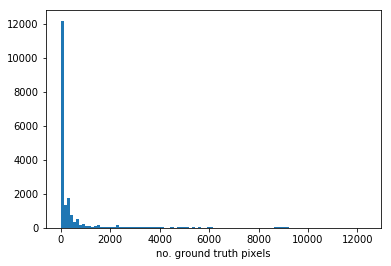

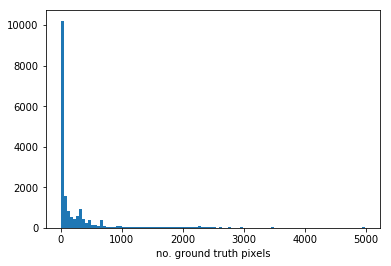

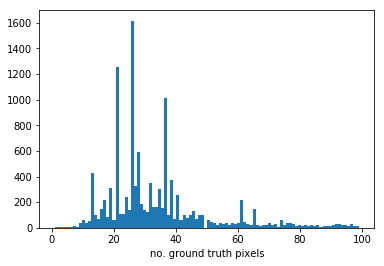

In [18]:
plt.figure()
plt.hist(counts,bins=100)
plt.xlabel('no. ground truth pixels')
plt.savefig('mr_hist.pdf',dpi=500)
plt.show()
plt.close()

plt.figure()
plt.hist(counts[counts<5000],bins=100)
plt.xlabel('no. ground truth pixels')
plt.savefig('mr_hist_red.pdf',dpi=500)
plt.show()
plt.close()

plt.figure()
plt.hist(counts[counts<100],bins=100)
plt.xlabel('no. ground truth pixels')
plt.savefig('mr_hist_red_2.pdf',dpi=500)
plt.show()
plt.close()

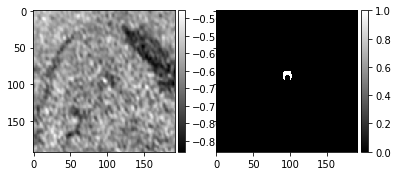

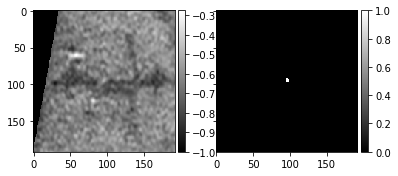

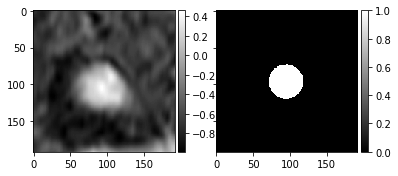

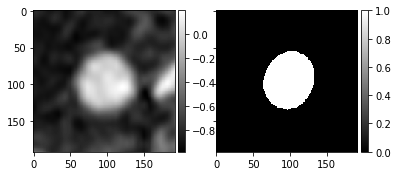

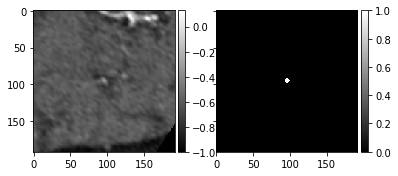

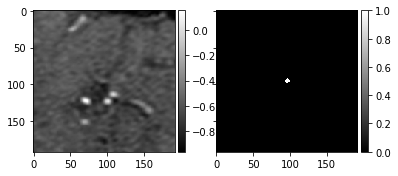

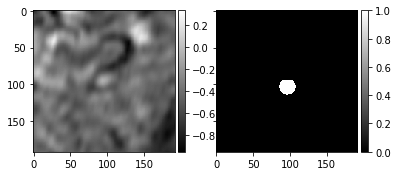

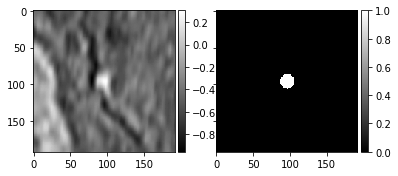

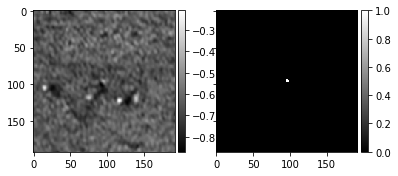

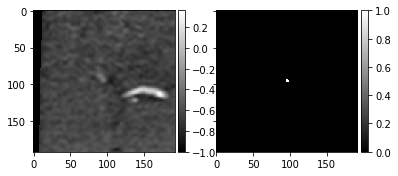

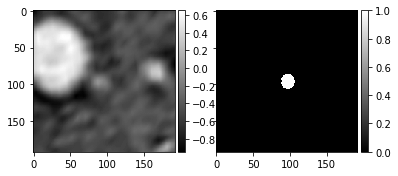

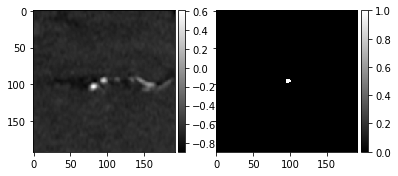

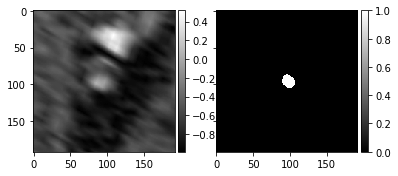

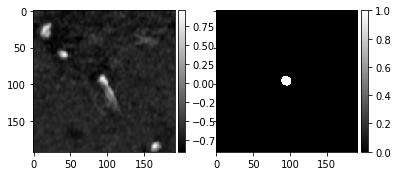

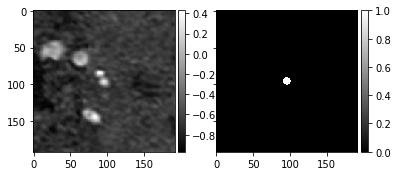

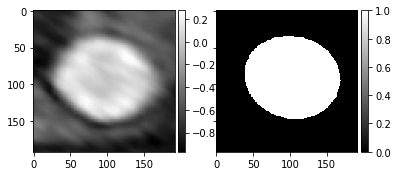

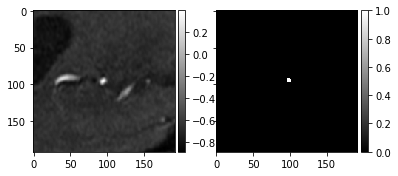

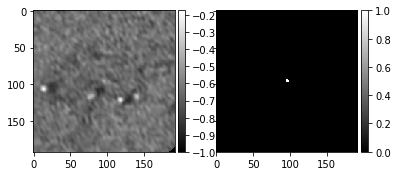

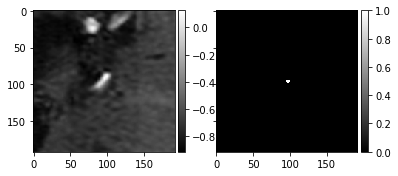

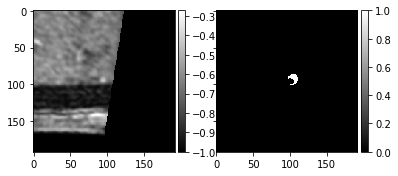

In [19]:
def implot(mp,ax):
    im = ax.imshow(mp.astype(np.float32), cmap='gray')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    
for i in range(20):
    j = np.random.randint(len(f.root.X))

    plt.figure()
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    implot(f.root.X[j,:,:,0],ax1)
    implot(f.root.Y[j,:,:,0],ax2)

    plt.tight_layout
    plt.show()
    
plt.close('all')

In [16]:
path_dict = utility.parsePathFile(paths[0])

In [17]:
print path_dict

{'200': {'points': array([[  2.32900000e-01,   1.78400000e-01,  -1.85725000e+01, ...,
          0.00000000e+00,   9.99979000e-01,  -6.50200000e-03],
       [  2.33019000e-01,   1.78446000e-01,  -1.85631840e+01, ...,
          0.00000000e+00,   9.99993000e-01,  -3.82600000e-03],
       [  2.33443000e-01,   1.78508000e-01,  -1.85364170e+01, ...,
          0.00000000e+00,   1.00000000e+00,  -7.56000000e-04],
       ..., 
       [  6.14020100e+00,  -1.05412300e+00,  -1.24546830e+01, ...,
          0.00000000e+00,   9.19807000e-01,   3.92371000e-01],
       [  6.16648400e+00,  -1.04618300e+00,  -1.24733310e+01, ...,
          0.00000000e+00,   9.20177000e-01,   3.91503000e-01],
       [  6.20330000e+00,  -1.03500000e+00,  -1.24996000e+01, ...,
          0.00000000e+00,   9.20076000e-01,   3.91739000e-01]]), 'name': 'brchcph'}, '900': {'points': array([[ -1.25550000e+00,   2.71710000e+00,   4.81120000e+00,
          5.27392000e-01,   6.17560000e-01,   5.83504000e-01,
          0.00000000e+00

In [18]:
print path_dict['200']
print type(path_dict['200']['points'])

{'points': array([[  2.32900000e-01,   1.78400000e-01,  -1.85725000e+01, ...,
          0.00000000e+00,   9.99979000e-01,  -6.50200000e-03],
       [  2.33019000e-01,   1.78446000e-01,  -1.85631840e+01, ...,
          0.00000000e+00,   9.99993000e-01,  -3.82600000e-03],
       [  2.33443000e-01,   1.78508000e-01,  -1.85364170e+01, ...,
          0.00000000e+00,   1.00000000e+00,  -7.56000000e-04],
       ..., 
       [  6.14020100e+00,  -1.05412300e+00,  -1.24546830e+01, ...,
          0.00000000e+00,   9.19807000e-01,   3.92371000e-01],
       [  6.16648400e+00,  -1.04618300e+00,  -1.24733310e+01, ...,
          0.00000000e+00,   9.20177000e-01,   3.91503000e-01],
       [  6.20330000e+00,  -1.03500000e+00,  -1.24996000e+01, ...,
          0.00000000e+00,   9.20076000e-01,   3.91739000e-01]]), 'name': 'brchcph'}
<type 'numpy.ndarray'>


In [19]:
img_fn = mhas[0]
truth_fn = truths[0]
path_fn = paths[0]
reader = vtk.vtkMetaImageReader()
reader2 = vtk.vtkMetaImageReader()

img_name = img_fn.split('/')[-2]

reader.SetFileName(img_fn)
reader.Update()
the_image = reader.GetOutput()

model = truth_fn
model_name = model.split('/')[-2]

print img_fn,truth_fn

reader2.SetFileName(model)
reader2.Update()
the_model = reader2.GetOutput()

path_dict = utility.parsePathFile(path_fn)

/home/marsdenlab/datasets/vascular_data/OSMSC0001/OSMSC0001-cm.mha /home/marsdenlab/datasets/vascular_data/OSMSC0001/0001_0001/0001_0001-cm.mha


In [20]:
normalizer = ct_norm
spacing = the_image.GetSpacing()
dims = the_image.GetDimensions()
origin = [-ext[0]*spacing[0]/2,ext[1]*spacing[1]/2]
minmax = the_image.GetScalarRange()    

tmpimages = utility.getAllImageSlices(the_image, path_dict, ext, True)
tmpsegs = utility.getAllImageSlices(the_model, path_dict, ext, True)

tmpimages = np.asarray(tmpimages)
tmpsegs = np.asarray(tmpsegs)

tmpimages = np.transpose(tmpimages,axes=(0,2,3,1))
tmpsegs = np.transpose(tmpsegs,axes=(0,2,3,1))

tmpimages = normalizer(tmpimages)
tmpsegs = 1.0*tmpsegs/np.amax(tmpsegs)
inds = [i for i in range(len(tmpimages)) if np.sum(tmpsegs[i])>0]

ValueError: axes don't match array

In [11]:
print len(tmpimages)
print len(tmpsegs)
print len(inds)
print tmpsegs[0].shape

NameError: name 'tmpimages' is not defined

In [10]:
# /home/marsdenlab/datasets/vascular_data/OSMSC0189/OSMSC0189-cm.mha
# /home/marsdenlab/datasets/vascular_data/cabg10/cabg10-image.mha
# /home/marsdenlab/datasets/vascular_data/cabg11/cabg11-image.mha
# /home/marsdenlab/datasets/vascular_data/cabg5/cabg5-image.mha

# /media/marsdenlab/Data2/datasets/DeepLofting/OOF/OSMSC0188-cm_oof.mha
# /media/marsdenlab/Data2/datasets/DeepLofting/OOF/OSMSC0189-cm_oof.mha
# /media/marsdenlab/Data2/datasets/DeepLofting/OOF/cabg10-image_oof.mha
# /media/marsdenlab/Data2/datasets/DeepLofting/OOF/cabg11-image_oof

oof_ct_tups = []
oof_mr_tups = []
def oof_norm(x):
    return x

for t in ct_test_tups:
    s = t[0]
    im_name = s.split('/')[-2]
    s = s.replace('/'+im_name+'/','/')
    s = s.replace('/home/marsdenlab/datasets/vascular_data','/media/marsdenlab/Data2/datasets/DeepLofting/OOF')
    s = s.replace('.mha','_oof.mha')
    print s
    
    oof_ct_tups.append((s,t[1],t[2],t[3]))
    
for t in mr_test_tups:
    s = t[0]
    im_name = s.split('/')[-2]
    s = s.replace('/'+im_name+'/','/')
    s = s.replace('/home/marsdenlab/datasets/vascular_data','/media/marsdenlab/Data2/datasets/DeepLofting/OOF')
    s = s.replace('.mha','_oof.mha')
    print s
    
    oof_mr_tups.append((s,t[1],t[2],t[3]))
    
print oof_ct_tups

/media/marsdenlab/Data2/datasets/DeepLofting/OOF/OSMSC0004-cm_oof.mha
/media/marsdenlab/Data2/datasets/DeepLofting/OOF/OSMSC0119-cm_oof.mha
/media/marsdenlab/Data2/datasets/DeepLofting/OOF/OSMSC0144-cm_oof.mha
/media/marsdenlab/Data2/datasets/DeepLofting/OOF/OSMSC0148-cm_oof.mha
/media/marsdenlab/Data2/datasets/DeepLofting/OOF/OSMSC0150-cm_oof.mha
/media/marsdenlab/Data2/datasets/DeepLofting/OOF/OSMSC0177-cm_oof.mha
/media/marsdenlab/Data2/datasets/DeepLofting/OOF/OSMSC0179-cm_oof.mha
/media/marsdenlab/Data2/datasets/DeepLofting/OOF/cabg11-image_oof.mha
/media/marsdenlab/Data2/datasets/DeepLofting/OOF/OSMSC0006-cm_oof.mha
/media/marsdenlab/Data2/datasets/DeepLofting/OOF/OSMSC0101-cm_oof.mha
/media/marsdenlab/Data2/datasets/DeepLofting/OOF/OSMSC0110-cm_oof.mha
/media/marsdenlab/Data2/datasets/DeepLofting/OOF/OSMSC0171-cm_oof.mha
/media/marsdenlab/Data2/datasets/DeepLofting/OOF/OSMSC0178-cm_oof.mha
[('/media/marsdenlab/Data2/datasets/DeepLofting/OOF/OSMSC0004-cm_oof.mha', '/home/marsdenl

In [55]:
IMAGE_NUMBER = 0
reader = vtk.vtkMetaImageReader()
reader.SetFileName(oof_ct_tups[IMAGE_NUMBER][0])
reader.Update()
im = reader.GetOutput()

spacing = im.GetSpacing()
print spacing

im = resample_image(im)
spacing = im.GetSpacing()
print spacing

print mhas[IMAGE_NUMBER]

(0.05859379842877388, 0.05859379842877388, 0.09000000357627869)
(0.05859379842877388, 0.05859379842877388, 0.05859379842877388)
/home/marsdenlab/datasets/vascular_data/OSMSC0001/OSMSC0001-cm.mha


In [56]:
IMAGE_NUMBER = 3
grp_files = os.listdir(groups[IMAGE_NUMBER])
print grp_files
# print grp_files[16]
group_dict = utility.parseGroupFile(groups[IMAGE_NUMBER]+'/'+grp_files[0])

path_dict = utility.parsePathFile(paths[IMAGE_NUMBER])
print path_dict.keys()
print group_dict.keys()

# path = 'aorta'
# grpid = '100'

# path = 'L_incrd_b12'
# grpid = '212'

path = 'profunda_branch_left'
grpid = '11'

# path = 'aorta'
# grpid = '1'

norm_grps = normalize_grps(group_dict,path_dict[grpid]['points'])

tmpimages = []
for v in path_dict[grpid]['points']:
    i =utility.getImageReslice(im,ext,v[:3],v[3:6],v[6:9], True)
    tmpimages.append(i)

grp_images_oof = []
for a in sorted(group_dict.keys()):
    v = group_dict[a]['points']
    i =utility.getImageReslice(im,ext,v[:3],v[3:6],v[6:9], True)
    grp_images_oof.append(i)

interp_grps = reinterp_grps(norm_grps)
print interp_grps[0]
lofted_grps, xs,ys = loft_path(interp_grps,sorted(group_dict.keys()),len(path_dict[grpid]['points']))

origin = [-spacing[0]*96,spacing[1]*96]

segs = [utility.contourToSeg(c,origin,[192,192],spacing) for c in lofted_grps]

print len(tmpimages)
print len(norm_grps)
print len(grp_images_oof)

['posterior_tibial_right', 'renal_right', 'celiac', 'profunda_branch_left', 'knee_left', 'anterior_tibial_right', 'aorta_leg_right', 'internal_iliac_left', 'group_contents.tcl', 'profunda_branch_right', 'femoral_left', 'anterior_tibial_left', 'knee_right', 'leg_left', 'posterior_tibial_left', 'profunda_left', 'femoral_right', 'renal_left', 'internal_iliac_right', 'superior_mesenteric_artery', 'profunda_right']
['11', '10', '13', '12', '15', '14', '17', '16', '19', '18', '20', '1', '3', '2', '5', '4', '7', '6', '9', '8']
[0, 3, 5, 8, 12, 15, 19, 23, 27, 31, 35, 39, 44, 49, 55, 60, 65, 69, 73, 78, 82, 87, 90, 93, 98]
[[ -4.55252341e+07  -3.43430234e+07]
 [ -4.31172301e+07  -3.25264947e+07]
 [ -3.96670739e+07  -2.99237943e+07]
 [ -3.54118353e+07  -2.67137610e+07]
 [ -3.05885843e+07  -2.30752337e+07]
 [ -2.54343910e+07  -1.91870515e+07]
 [ -2.01863251e+07  -1.52280532e+07]
 [ -1.50814568e+07  -1.13770778e+07]
 [ -1.03568559e+07  -7.81296416e+06]
 [ -6.24959245e+06  -4.71455128e+06]
 [ -2.9

In [11]:
oof_test_ct = '/media/marsdenlab/Data2/datasets/DeepLofting/test_192_ct_oof.hdf5'
oof_test_mr = '/media/marsdenlab/Data2/datasets/DeepLofting/test_192_mr_oof.hdf5'

In [12]:
d = np.dtype(np.float16)
THE_FILE = open('oof_mr_list.txt','w')
images_to_hdf5(oof_ct_tups,
                   image_reader,
                   process_image, ct_norm, (ext[0]+1,ext[1]+1,1), (ext[0]+1,ext[1]+1,1), d, d,
                   oof_test_ct)
THE_FILE.close()

THE_FILE = open('oof_mr_list.txt','w')
images_to_hdf5(oof_mr_tups,
                   image_reader,
                   process_image, mr_norm, (ext[0]+1,ext[1]+1,1), (ext[0]+1,ext[1]+1,1), d, d,
                   oof_test_mr)
THE_FILE.close()

image 0
/media/marsdenlab/Data2/datasets/DeepLofting/OOF/OSMSC0004-cm_oof.mha /home/marsdenlab/datasets/vascular_data/OSMSC0004/0004_0001/0004_0001-cm.mha
grp profunda_branch_left exists, getting images
grp profunda_left exists, getting images
grp knee_right exists, getting images
grp profunda_branch_right exists, getting images
grp anterior_tibial_right exists, getting images
grp knee_left exists, getting images
grp anterior_tibial_left exists, getting images
grp posterior_tibial_right exists, getting images
grp femoral_right exists, getting images
grp posterior_tibial_left exists, getting images
grp femoral_left exists, getting images
grp aorta_leg_right exists, getting images
grp celiac exists, getting images
grp leg_left exists, getting images
grp renal_right exists, getting images
grp superior_mesenteric_artery exists, getting images
grp internal_iliac_right exists, getting images
grp renal_left exists, getting images
grp profunda_right exists, getting images
grp internal_iliac_le

grp renal_right exists, getting images
grp RSA exists, getting images
grp aorta exists, getting images
grp in_iliac_right exists, getting images
grp LSA exists, getting images
grp in_iliac_left exists, getting images
grp LCCA exists, getting images
grp celiac_splenic exists, getting images
grp celiac_hepatic exists, getting images
grp SMA exists, getting images
grp dc_1 exists, getting images
grp disection exists, getting images
(4950, 192, 192, 1) (4950, 192, 192, 1)
[[ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]]
(4724, 2)
done appending
image 6
/media/marsdenlab/Data2/datasets/DeepLofting/OOF/OSMSC0179-cm_oof.mha /home/marsdenlab/datasets/vascular_data/OSMSC0179/0179_0001/0179_0001-cm.mha
grp R_vtbrl_i exists, getting images
grp C_ant exists, getting images
grp L_incrd exists, getting images
grp L_ant exists, getting images
grp aneurysm_1 exists, getting images


In [11]:
mhas = open('images.txt').readlines()
mhas = [i.replace('\n','') for i in mhas]

truths = open('truths.txt').readlines()
truths = [i.replace('\n','') for i in truths]

paths = open('paths.txt').readlines()
paths = [i.replace('\n','') for i in paths]

groups = open('groups.txt').readlines()
groups = [i.replace('\n','') for i in groups]

ct_test = open('ct_test.txt').readlines()
ct_test = [i.replace('\n','') for i in ct_test]

mr_test = open('mr_test.txt').readlines()
mr_test = [i.replace('\n','') for i in mr_test]

In [12]:
volumes_dir = "/media/marsdenlab/Data2/datasets/DeepLofting/i2i3d/"
i2i_images = os.listdir(volumes_dir)
print i2i_images
test_images = []
ct_test = sorted(ct_test)
for v in ct_test:
    image_name = v
    print v

    ind = [i for i in range(len(mhas)) if image_name in mhas[i]][0]
    
    i2i_name = [i for i in i2i_images if v in i][0]
    
    test_images.append((volumes_dir+v+'_i2i3d.mha',truths[ind],paths[ind],groups[ind]))
    
print test_images

['OSMSC0078_i2i3d.mha', 'OSMSC0006_i2i3d.mha', 'OSMSC0150_i2i3d.mha', 'OSMSC0148_i2i3d.mha', 'OSMSC0113_i2i3d.mha', 'OSMSC0179_i2i3d.mha', 'cabg11_i2i3d.mha', 'OSMSC0177_i2i3d.mha', 'OSMSC0171_i2i3d.mha', 'OSMSC0118_i2i3d.mha', 'OSMSC0144_i2i3d.mha', 'OSMSC0180_i2i3d.mha', 'OSMSC0129_i2i3d.mha', 'OSMSC0004_i2i3d.mha', 'OSMSC0101_i2i3d.mha', 'OSMSC0178_i2i3d.mha', 'OSMSC0110_i2i3d.mha', 'OSMSC0119_i2i3d.mha']
OSMSC0004
OSMSC0119
OSMSC0144
OSMSC0148
OSMSC0150
OSMSC0177
OSMSC0179
cabg11
[('/media/marsdenlab/Data2/datasets/DeepLofting/i2i3d/OSMSC0004_i2i3d.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0004/0004_0001/0004_0001-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0004/0004_0001/0004_0001-cm.paths', '/home/marsdenlab/datasets/vascular_data/OSMSC0004/0004_0001/0004_0001_groups-cm'), ('/media/marsdenlab/Data2/datasets/DeepLofting/i2i3d/OSMSC0119_i2i3d.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0119/0119_0001/0119_0001-cm.mha', '/home/marsdenlab/datasets/vascula

In [13]:
i2i3d_test_ct = '/media/marsdenlab/Data2/datasets/DeepLofting/test_192_ct_i2i3d.hdf5'

def norm(x):
    return 1.0*x

In [14]:
d = np.dtype(np.float16)
THE_FILE = open('i2i3d.txt','w')
images_to_hdf5(test_images,
                   image_reader,
                   process_image, norm, (ext[0]+1,ext[1]+1,1), (ext[0]+1,ext[1]+1,1), d, d,
                   i2i3d_test_ct)
THE_FILE.close()

# tup = image_reader(test_images[1])
# data = get_image(tup,norm)

# THE_FILE = open('i2i3d.txt','w')
# tup = image_reader(test_images[2])
# data = get_image(tup,norm)
# THE_FILE.close()

# tup_ = image_reader(test_images[1])
# data_ = get_image(tup,norm)

image 0
/media/marsdenlab/Data2/datasets/DeepLofting/i2i3d/OSMSC0004_i2i3d.mha /home/marsdenlab/datasets/vascular_data/OSMSC0004/0004_0001/0004_0001-cm.mha
grp profunda_branch_left exists, getting images
grp profunda_left exists, getting images
grp knee_right exists, getting images
grp profunda_branch_right exists, getting images
grp anterior_tibial_right exists, getting images
grp knee_left exists, getting images
grp anterior_tibial_left exists, getting images
grp posterior_tibial_right exists, getting images
grp femoral_right exists, getting images
grp posterior_tibial_left exists, getting images
grp femoral_left exists, getting images
grp aorta_leg_right exists, getting images
grp celiac exists, getting images
grp leg_left exists, getting images
grp renal_right exists, getting images
grp superior_mesenteric_artery exists, getting images
grp internal_iliac_right exists, getting images
grp renal_left exists, getting images
grp profunda_right exists, getting images
grp internal_iliac_l

grp ext_iliac_left exists, getting images
grp renal_right exists, getting images
grp RSA exists, getting images
grp aorta exists, getting images
grp in_iliac_right exists, getting images
grp LSA exists, getting images
grp in_iliac_left exists, getting images
grp LCCA exists, getting images
grp celiac_splenic exists, getting images
grp celiac_hepatic exists, getting images
grp SMA exists, getting images
grp dc_1 exists, getting images
grp disection exists, getting images
(4950, 192, 192, 1) (4950, 192, 192, 1)
[[ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]]
(4724, 2)
done appending
image 6
/media/marsdenlab/Data2/datasets/DeepLofting/i2i3d/OSMSC0179_i2i3d.mha /home/marsdenlab/datasets/vascular_data/OSMSC0179/0179_0001/0179_0001-cm.mha
grp R_vtbrl_i exists, getting images
grp C_ant exists, getting images
grp L_incrd exists, getting images
grp L_ant exists, getting im

In [15]:
f = tables.open_file('/media/marsdenlab/Data2/datasets/DeepLofting/test_192_ct_i2i3d.hdf5')

In [16]:
file_ = open('i2i3d.txt','r').readlines()
print len(file_)
print data[0].shape
grp = 'disection'
loc = '214'
indexes = [i for i in range(len(file_)) if grp in file_[i]]

PLOT_INDEX = 13138
#PLOT_INDEX = 12981
#PLOT_INDEX = 11320

img2 = f.root.X[PLOT_INDEX,:,:,0]
imgy = f.root.Y[PLOT_INDEX,:,:,0]

plt.figure()
plt.imshow(img2.astype(np.float32))
plt.show()
plt.close()

plt.figure()
plt.imshow(imgy.astype(np.float32))
plt.show()
plt.close()


for i in indexes[::10]:
    print file_[i]
    
    img = data[0][i,:,:,0]
    plt.figure()
    plt.imshow(img.astype(np.float32),cmap='gray')
    plt.show()
    plt.close()

42694


NameError: name 'data' is not defined

In [17]:
ypred = f.root.X
truth = f.root.Y
print ypred.shape
print truth.shape

(42694, 192, 192, 1)
(42694, 192, 192, 1)


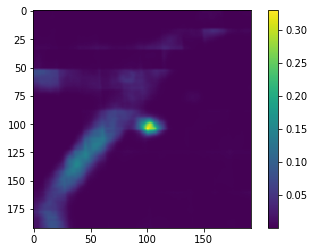

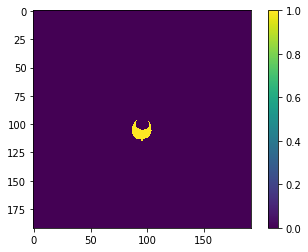

In [24]:
N = ypred.shape[0]
i = np.random.randint(N)
plt.figure()
plt.imshow(ypred[i,:,:,0].astype(float))
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(truth[i,:,:,0].astype(float))
plt.colorbar()
plt.show()

In [25]:
conts = []
yp = utility.threshold(ypred,0.1)
for i in range(N):
    if i %1000==0:
        print i
    seg = yp[i,:,:,0]
    cont = utility.marchingSquares(seg.astype(np.float32),iso=0.1,mode='center')
    conts.append(cont.copy())
    

np.save('i2i_3d_conts_ct.npy',conts)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000


In [26]:
volumes_dir = "/media/marsdenlab/Data2/datasets/DeepLofting/i2i3d/"
i2i_images = os.listdir(volumes_dir)
print i2i_images
test_images = []
mr_test = sorted(mr_test)
for v in mr_test:
    image_name = v
    print v

    ind = [i for i in range(len(mhas)) if image_name in mhas[i]][0]
    
    i2i_name = [i for i in i2i_images if v in i][0]
    
    test_images.append((volumes_dir+v+'_i2i3d.mha',truths[ind],paths[ind],groups[ind]))
    
print test_images

['OSMSC0078_i2i3d.mha', 'OSMSC0006_i2i3d.mha', 'OSMSC0150_i2i3d.mha', 'OSMSC0148_i2i3d.mha', 'OSMSC0113_i2i3d.mha', 'OSMSC0179_i2i3d.mha', 'cabg11_i2i3d.mha', 'OSMSC0177_i2i3d.mha', 'OSMSC0171_i2i3d.mha', 'OSMSC0118_i2i3d.mha', 'OSMSC0144_i2i3d.mha', 'OSMSC0180_i2i3d.mha', 'OSMSC0129_i2i3d.mha', 'OSMSC0004_i2i3d.mha', 'OSMSC0101_i2i3d.mha', 'OSMSC0178_i2i3d.mha', 'OSMSC0110_i2i3d.mha', 'OSMSC0119_i2i3d.mha']
OSMSC0006
OSMSC0101
OSMSC0110
OSMSC0171
OSMSC0178
[('/media/marsdenlab/Data2/datasets/DeepLofting/i2i3d/OSMSC0006_i2i3d.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0006/0006_0001/0006_0001-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0006/0006_0001/0006_0001-cm.paths', '/home/marsdenlab/datasets/vascular_data/OSMSC0006/0006_0001/0006_0001_groups-cm'), ('/media/marsdenlab/Data2/datasets/DeepLofting/i2i3d/OSMSC0101_i2i3d.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0101/0101_0001/0101_0001-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0101/0101_0001/

In [27]:
i2i3d_test_mr = '/media/marsdenlab/Data2/datasets/DeepLofting/test_192_mr_i2i3d.hdf5'

def norm(x):
    return 1.0*x

In [28]:
d = np.dtype(np.float16)
THE_FILE = open('i2i3d.txt','w')
images_to_hdf5(test_images,
                   image_reader,
                   process_image, norm, (ext[0]+1,ext[1]+1,1), (ext[0]+1,ext[1]+1,1), d, d,
                   i2i3d_test_mr)
THE_FILE.close()

image 0
/media/marsdenlab/Data2/datasets/DeepLofting/i2i3d/OSMSC0006_i2i3d.mha /home/marsdenlab/datasets/vascular_data/OSMSC0006/0006_0001/0006_0001-cm.mha
grp right_iliac exists, getting images
grp celiac_branch exists, getting images
grp left_internal_iliac exists, getting images
grp celiac_trunk exists, getting images
grp renal_right exists, getting images
grp right_internal_iliac exists, getting images
grp renal_left exists, getting images
grp aorta exists, getting images
grp superior_mesentaric exists, getting images
(875, 192, 192, 1) (875, 192, 192, 1)
[[ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]
 [ 0.025  0.025]]
(875, 2)
done appending
image 1
/media/marsdenlab/Data2/datasets/DeepLofting/i2i3d/OSMSC0101_i2i3d.mha /home/marsdenlab/datasets/vascular_data/OSMSC0101/0101_0001/0101_0001-cm.mha
image 2
/media/marsdenlab/Data2/datasets/DeepLofting/i2i3d/OSMSC0110_i2i3d.mha /hom

In [29]:
f = tables.open_file('/media/marsdenlab/Data2/datasets/DeepLofting/test_192_mr_i2i3d.hdf5')

In [30]:
ypred = f.root.X
truth = f.root.Y
print ypred.shape
print truth.shape
N = truth.shape[0]

(16442, 192, 192, 1)
(16442, 192, 192, 1)


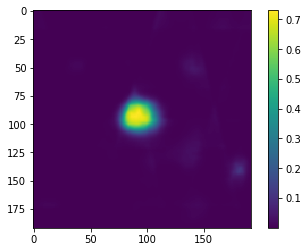

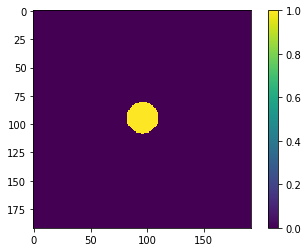

In [42]:
N = ypred.shape[0]
i = np.random.randint(N)
plt.figure()
plt.imshow(ypred[i,:,:,0].astype(float))
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(truth[i,:,:,0].astype(float))
plt.colorbar()
plt.show()

In [32]:
conts = []
yp = utility.threshold(ypred,0.1)
for i in range(N):
    if i %1000==0:
        print i
    seg = yp[i,:,:,0]
    cont = utility.marchingSquares(seg.astype(np.float32),iso=0.1,mode='center')
    conts.append(cont.copy())
    

np.save('i2i_3d_conts_mr.npy',conts)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
